<a href="https://colab.research.google.com/github/cu-applied-math/SciML-Class/blob/lab_solutions/Labs/lab07_optimization_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: optimization (Solutions)
We'll explore what's in [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) and when-to-use-which-function.

[`jax.scipy.optimize.minimize`](https://jax.readthedocs.io/en/latest/_autosummary/jax.scipy.optimize.minimize.html) is another option

These optimization packages are not that extensive, and generally do note have anything recent, but a few of their methods are good.

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.optimize as opt
from scipy import linalg
from time import time
import warnings

## (1) write your own Newton Solver
And use it to try to minimize the given function $f$ below


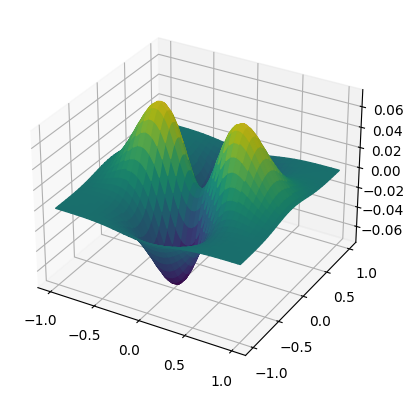

In [ ]:
def f(x):
    return jnp.exp( -(x[0]**2 + x[1]**2)/0.2  )  * (x[0]**2 - x[1]**2)
Grad = jax.jit(jax.grad(f))
Hess = jax.jit(jax.hessian(f))

# == Plot it ==
nGridX = 70
nGridY = 70
Xgrid, Ygrid = jnp.meshgrid(jnp.linspace(-1, 1, nGridX), jnp.linspace(-1, 1, nGridY))

XYgrid = jnp.vstack((jnp.expand_dims(Xgrid,0), jnp.expand_dims(Ygrid,0)))
F      = f(XYgrid) # may need to do vmap, depending on how f is defined...
norm = plt.Normalize(F.min(), F.max())
colors = cm.viridis(norm(F))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface( Xgrid, Ygrid, F,facecolors=colors )#,rstride=3,cstride=3)
# surf.set_facecolor((1,1,1,.35))

In [ ]:
def NewtonsMethod(f,grad,Hess,x0,tol=1e-6,maxIters=1e2,printEvery=1):
  x   = x0
  maxIters = int(maxIters)
  print("Iter.  Objective ")
  print("-----  ---------")

  ## Main loop
  flag = "Quitting due to reaching max iterations"
  for k in range(maxIters+1):
    ## Actual math:
    g   = grad(x)
    H   = Hess(x)
    p   = -linalg.solve(H,g) # Newton step
    xNew = x + p
    fNew = f(xNew)

    if (not k % printEvery) :  # modulo
        print(f"{k:5d}  {fNew:7.2e}")

    # Check for convergence
    if np.allclose(xNew,x,rtol=tol, atol=1e-3*tol):
      break

    # Get ready for next iteration
    x  = xNew

  return x

In [ ]:
x0  = jnp.array([0.,.1])
x = NewtonsMethod(f,Grad,Hess,x0)

print(x)
print(f(x))

Iter.  Objective 
-----  ---------
    0  -6.65e-04
    1  -1.22e-07
    2  -7.33e-19
    3  0.00e+00
[ 0.00000000e+00 -8.56282941e-10]
-7.332204752044752e-19


**Observation**
We converge very quickly, but not to the right thing!!  We've found a stationary point, i.e., a point that has zero (or in practice, very small) gradient.

However, this is basically the point $x=0(0,0)$, and $f(x)=0$. But looking at the plot, we know we can do much better. In the valley, we should find a point that has objective value closer to $-0.07$.

What went wrong?  Nothing: Newton did what it is supposed to do, which is find a zero of the gradient, i.e., a stationary point. But for a non-convex problem, that's not the same as finding a local minimizer (much less a global minimizer).

Gradient descent, on the other hand, doesn't coverge so quickly, so it has time to follow its nose downhill.  For nicer plots, see this [demo from APPM 5630](https://github.com/stephenbeckr/convex-optimization-class/blob/master/Demos/nonconvex_example_2D.ipynb)

### (1) extra
Going farther,
- solve this problem using gradient descent (starting at the same point)
- solve this problem using `scipy.optimize`, especially their `Newton-CG` method.  Do get the same results?  Are they implementing a "pure" Newton method?

For gradient descent, you can use some prewritten code:

In [ ]:
!wget -nv 'https://raw.githubusercontent.com/stephenbeckr/convex-optimization-class/refs/heads/master/utilities/firstOrderMethods.py'
from firstOrderMethods import gradientDescent

2024-10-04 19:44:28 URL:https://raw.githubusercontent.com/stephenbeckr/convex-optimization-class/refs/heads/master/utilities/firstOrderMethods.py [33642/33642] -> "firstOrderMethods.py" [1]


In [ ]:
x, out = gradientDescent(f,Grad,x0,printEvery=1)
print(x)

Iter.  Objective Stepsize
-----  --------- --------
    0  -5.31e-02  1.00e+00
    1  -6.89e-02  3.84e-01
    2  -7.23e-02  3.11e-01
    3  -7.32e-02  3.11e-01
    4  -7.35e-02  3.08e-01
    5  -7.35e-02  3.08e-01
    6  -7.36e-02  3.04e-01
    7  -7.36e-02  3.04e-01
    8  -7.36e-02  3.35e-01
    9  -7.36e-02  3.32e-01
   10  -7.36e-02  3.32e-01
   11  -7.36e-02  3.28e-01
   11  -7.36e-02  3.28e-01
==  Quitting due to stagnating objective value  ==
[0.         0.44708206]


**Discussion**
As mentioned above, gradient descent does work fine. It takes more iterations than Newton, but actually finds the local minimizer.

Let's try an optimizer from scipy. We can even use it's "Newtons method", but note that they undoubtedly do a safeguarded Newton that has a linesearch, and this should prevent it from converging to local maxima at least. It will also often help avoid saddle points (though to *properly* avoid saddle points, use the trust-region method)

In [ ]:
x0  = jnp.array([0,1e-8])
opts = {'disp':True}
# opt.show_options('minimize','Newton-CG') # shows available options
out = opt.minimize(f, x0, method='Newton-CG', jac=Grad, hess=Hess, tol=1e-10,options=opts)
print(out)
Grad(out.x)

Optimization terminated successfully.
         Current function value: -0.073576
         Iterations: 6
         Function evaluations: 38
         Gradient evaluations: 38
         Hessian evaluations: 6
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.07357588823428847
       x: [ 0.000e+00  4.472e-01]
     nit: 6
     jac: [ 0.000e+00 -7.163e-11]
    nfev: 38
    njev: 38
    nhev: 6


Array([ 0.0000000e+00, -7.1628721e-11], dtype=float64)

**Discussion** We see from above that we match the result of gradient descent, showing that their implementation of Newton helped it avoid that saddle point that caused problems for our pure Newton

In [ ]:
out = opt.minimize(f, x0, method='trust-constr', jac=Grad, hess=Hess, tol=1e-10,options=opts)
print(out)
Grad(out.x)

`xtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 12, CG iterations: 20, optimality: 2.24e-09, constraint violation: 0.00e+00, execution time: 0.14 s.
          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -0.07357588823428847
                x: [ 0.000e+00  4.472e-01]
              nit: 21
             nfev: 12
             njev: 6
             nhev: 6
         cg_niter: 20
     cg_stop_cond: 2
             grad: [ 0.000e+00 -2.242e-09]
  lagrangian_grad: [ 0.000e+00 -2.242e-09]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 2.2423696137215204e-09
 constr_violation: 0
   execution_time: 0.14348363876342773
        tr_radius: 9.524050768663125e-11
   constr_penalty: 1.0
            niter: 21


Array([ 0.00000000e+00, -2.24236961e-09], dtype=float64)

**Discussion** The `trust-constr` method is an even better method than Newton when dealing with nonconvex problems, and we see that it also worked fine

## (2) Solve 2D Rosenbrock

Starting at the point $x = (-1,3)$


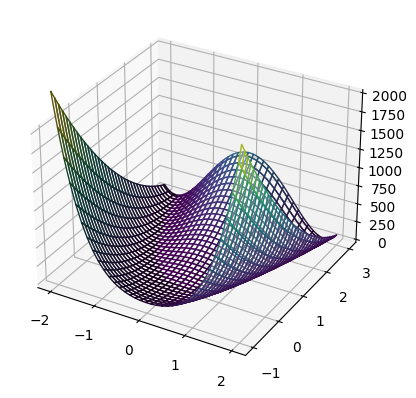

In [ ]:
a, b = 1., 100. # usual parameters for Rosenbrock
def f(x):
    return (a-x[0])**2 + b*(x[1]-x[0]**2)**2
# We can also use https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.rosen.html#scipy.optimize.rosen
#   as well as `rosen_der` and `rosen_hess`, since they are pre-implemented as common test functions,
#   but only for 2D

Grad = jax.jit(jax.grad(f))
Hess = jax.jit(jax.hessian(f))

xOptimal = jnp.ones((2,1)) # if a = 1 (in general, at (a,a^2) )

# == Plot it ==
nGridX = 70
nGridY = 70
Xgrid, Ygrid = jnp.meshgrid(jnp.linspace(-2, 2, nGridX), jnp.linspace(-1, 3, nGridY))

XYgrid = jnp.vstack((jnp.expand_dims(Xgrid,0), jnp.expand_dims(Ygrid,0)))
F      = f(XYgrid) # may need to do vmap, depending on how f is defined...
norm = plt.Normalize(F.min(), F.max())
colors = cm.viridis(norm(F))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface( Xgrid, Ygrid, F,facecolors=colors)#,rstride=3,cstride=3)
ax.set_zlim(0, 2000)
surf.set_facecolor((1,1,1,.35))

In [ ]:
errFcn = lambda x : np.linalg.norm(x-xOptimal.ravel())
# def myCallback(x):
#     print(f'Error: {np.linalg.norm(x-xOptimal.ravel()):.2e}')

opts = {'disp':False}
x0 = jnp.array([-1,3.])

nFcnEvalList = []
errList      = []
methods = ['BFGS','L-BFGS-B','Newton-CG','Nelder-Mead','Powell','CG','trust-constr','TNC',
           'COBYLA','SLSQP','dogleg','trust-ncg','trust-exact','trust-krylov']
           # For some reason it can't find COBYQA
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    # Supress the warnings about methods that ignore the Hessian or gradient information

    for meth in methods:
        out = opt.minimize(f, x0, method=meth, jac=Grad, hess=Hess, tol=1e-10, options=opts)
        errList.append(errFcn(out.x))
        nFcnEvalList.append(out.nfev)

In [ ]:
methods = ['BFGS','L-BFGS-B','Newton-CG','Nelder-Mead','Powell','CG','trust-constr','TNC',
            'COBYLA','SLSQP','dogleg','trust-ncg','trust-exact','trust-krylov']
            # For some reason it can't find COBYQA
useGradient = [True]*len(methods)
useHessian  = [True]*len(methods)
for (j,meth) in enumerate(methods):
    with warnings.catch_warnings(record=True) as warn:
        warnings.simplefilter("always")
        out = opt.minimize(f, x0, method=meth, jac=Grad, hess=Hess, tol=1e-10,
                    options=opts )
        for i in range(len(warn)):
            if "hess" in str(warn[i].message):
                useHessian[j] = False
            if "grad" in str(warn[i].message):
                useGradient[j] = False

#### And now we can make a pretty markdown table

In [ ]:
print('| Method | Iterations | Error | use gradients? | use Hessians? |')
print('| -- | -- | -- | -- | -- |')
for (i,meth) in enumerate(methods):
    print(f'| {meth} | {nFcnEvalList[i]}  |  {errList[i]:.1e} | {useGradient[i]} | {useHessian[i]} |')

| Method | Iterations | Error | use gradients? | use Hessians? |
| -- | -- | -- | -- | -- |
| BFGS | 60  |  1.5e-12 | True | False |
| L-BFGS-B | 55  |  1.3e-10 | True | False |
| Newton-CG | 263  |  1.1e-11 | True | True |
| Nelder-Mead | 285  |  5.1e-12 | False | False |
| Powell | 1259  |  5.0e-16 | False | False |
| CG | 86  |  2.6e-14 | True | False |
| trust-constr | 34  |  9.2e-16 | True | True |
| TNC | 74  |  1.2e-04 | True | False |
| COBYLA | 1000  |  2.0e+00 | False | False |
| SLSQP | 57  |  1.8e-06 | True | False |
| dogleg | 1  |  2.8e+00 | True | True |
| trust-ncg | 55  |  2.6e-14 | True | True |
| trust-exact | 32  |  0.0e+00 | True | True |
| trust-krylov | 51  |  3.8e-08 | True | True |


| Method | Iterations | Error | use gradients? | use Hessians? |
| -- | -- | -- | -- | -- |
| BFGS | 60  |  1.5e-12 | True | False |
| L-BFGS-B | 55  |  1.3e-10 | True | False |
| Newton-CG | 263  |  1.1e-11 | True | True |
| Nelder-Mead | 285  |  5.1e-12 | False | False |
| Powell | 1259  |  5.0e-16 | False | False |
| CG | 86  |  2.6e-14 | True | False |
| trust-constr | 34  |  9.2e-16 | True | True |
| TNC | 74  |  1.2e-04 | True | False |
| COBYLA | 1000  |  2.0e+00 | False | False |
| SLSQP | 57  |  1.8e-06 | True | False |
| dogleg | 1  |  2.8e+00 | True | True |
| trust-ncg | 55  |  2.6e-14 | True | True |
| trust-exact | 32  |  0.0e+00 | True | True |
| trust-krylov | 51  |  3.8e-08 | True | True |

## (3) Solve nD Rosenbrock
Start at the all zeros vector

Try it first for dimension $n=10$ to get the kinks out of your code and make sure everything works, then try for $n=1000$

In [ ]:
n = 1000  # dimension
for n in [10,1000]:

    def f_slow(x):
        """ Rosenbrock function in n dimensions;
        see https://en.wikipedia.org/wiki/Rosenbrock_function
        for n >= 4, there's a global min at (1,1,...,1)
        and a local min at (-1,1,1,..., 1)
        """
        s = 0.
        for i in range(x.shape[0]-1):
            s += 100*(x[i+1] - x[i]**2)**2 + (1-x[i])**2
        return s
    def f(x):
        """ Rosenbrock function in n dimensions;
        see https://en.wikipedia.org/wiki/Rosenbrock_function
        for n >= 4, there's a global min at (1,1,...,1)
        and a local min at (-1,1,1,..., 1)
        """
        s = jnp.linalg.norm( x[1:] - x[:-1]**2 )**2
        s += jnp.linalg.norm(1-x[:-1])**2
        return s

    Grad_slow = jax.jit(jax.grad(f_slow))
    Grad = jax.jit(jax.grad(f))
    Hess = jax.jit(jax.hessian(f))

    x0 = jnp.array([1e-1]*n)
    # x0 = jnp.zeros((n,)) # usually won't converge if starting from here

    start = time()
    g = Grad(x0)
    end = time()
    print(f'Time to calculate gradient (the first time) is  {end-start:.3f} seconds')
    start = time()
    g = Grad(x0)
    end = time()
    print(f'Time to calculate gradient (the second time) is {end-start:.3f} seconds')
    if n <= 100:
        print('--- and using the slower implementation --- ')
        start = time()
        g = Grad_slow(x0)
        end = time()
        print(f'Time to calculate gradient (the first time) is  {end-start:.3f} seconds')
        start = time()
        g = Grad_slow(x0)
        end = time()
        print(f'Time to calculate gradient (the second time) is {end-start:.3f} seconds')



    xOptimal = jnp.ones((n,1))
    errFcn = lambda x : np.linalg.norm(x-xOptimal.ravel())

    # def myCallback(x):
    #     print(f'Error: {np.linalg.norm(x-xOptimal.ravel()):.2e}')

    # out = opt.minimize(f, x0, method='L-BFGS-B', jac=Grad, callback=myCallback)
    # print(out)

    # This next bunch of code is just so that we can stop the optimizer
    # after 20 seconds
    class TookTooLong(Warning):
        pass

    class MinimizeStopper(object):
        """ from https://stackoverflow.com/a/24827245
        """
        def __init__(self, max_sec=60):
            self.max_sec = max_sec
            self.numberIterations = 0
            self.error = np.Inf
            self.start = time()
        def __call__(self, x, *args, **kwargs):
            self.numberIterations += 1
            elapsed = time() - self.start
            err = errFcn(x)
            if self.error > err:
                self.error = err
                # or really, if f(x) is minimal, then we could record
                # x as the best-so-far
            if elapsed > self.max_sec:
                #print(f'  Current error is {err:.2e}')
                warnings.warn("Terminating optimization: time limit reached",
                            TookTooLong)

    opts = {'disp':False}
    nFcnEvalList = []
    errList      = []
    timeList     = []
    methods = ['BFGS','L-BFGS-B','Newton-CG','Nelder-Mead','Powell','CG','trust-constr','TNC',
            'COBYLA','SLSQP','dogleg','trust-ncg','trust-exact','trust-krylov']
            # For some reason it can't find COBYQA

    timeLimit = 20 # in seonds
    print('')
    print(f'Time limit is {timeLimit} seconds, n is {n}')
    # (it's not a strict time limit, it just means the method won't take more iterations
    #  after we've detected it goes beyond this time limit )
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        #warnings.filterwarnings("default", category=RuntimeWarning)
        warnings.filterwarnings("error", category=TookTooLong) # stop if we exceed the given time

        for meth in methods:
            myCallback = MinimizeStopper(timeLimit)
            start = time()
            try:
                out = opt.minimize(f, x0, method=meth, jac=Grad, hess=Hess, tol=1e-10,
                            options=opts, callback=myCallback )
                errList.append(errFcn(out.x))
                nFcnEvalList.append(out.nfev)
            except TookTooLong:
                #print('  (ending execution due to exceeding time limit)')
                errList.append(myCallback.error)
                nFcnEvalList.append(myCallback.numberIterations)
            except:
                errList.append(np.Inf)
                nFcnEvalList.append(np.Inf)
                # raise
            timeList.append(time() - start)
            print(f'Method {meth:20s} took {float(nFcnEvalList[-1]):4.0f} iterations, error is {errList[-1]:5.2e}, time {timeList[-1]:5.1f} sec')


print('| Method | Iterations | Error | Time | use gradients? | use Hessians? |')
print('| -- | -- | -- | -- | -- | -- |')
for (i,meth) in enumerate(methods):
    print(f'| {meth} | {float(nFcnEvalList[i]):4.0f}  |  {errList[i]:5.1e} | {timeList[i]:.1f} sec. | {useGradient[i]} | {useHessian[i]} |')

Time to calculate gradient (the first time) is  0.078 seconds
Time to calculate gradient (the second time) is 0.001 seconds
--- and using the slower implementation --- 
Time to calculate gradient (the first time) is  0.240 seconds
Time to calculate gradient (the second time) is 0.001 seconds

Time limit is 20 seconds, n is 10
Method BFGS                 took   31 iterations, error is 3.61e-13, time   0.0 sec
Method L-BFGS-B             took   21 iterations, error is 2.21e-07, time   0.0 sec
Method Newton-CG            took   12 iterations, error is 1.36e-10, time   0.2 sec
Method Nelder-Mead          took 2000 iterations, error is 3.48e-02, time   1.0 sec
Method Powell               took 5482 iterations, error is 5.04e-12, time   2.0 sec
Method CG                   took  123 iterations, error is 1.87e-10, time   0.1 sec
Method trust-constr         took   18 iterations, error is 1.13e-10, time   0.1 sec
Method TNC                  took   44 iterations, error is 2.38e-06, time   0.0 sec


| Method | Iterations | Error | Time | use gradients? | use Hessians? |
| -- | -- | -- | -- | -- | -- |
| BFGS |  147  |  2.3e-11 | 19.0 sec. | True | False |
| L-BFGS-B |   33  |  3.3e-06 | 0.0 sec. | True | False |
| Newton-CG |   16  |  6.1e-10 | 0.5 sec. | True | True |
| Nelder-Mead | 2650  |  2.8e+01 | 20.0 sec. | False | False |
| Powell |    2  |  7.6e+00 | 25.8 sec. | False | False |
| CG |  141  |  8.8e-11 | 0.2 sec. | True | False |
| trust-constr |   19  |  1.0e-11 | 0.8 sec. | True | True |
| TNC |  123  |  7.5e-06 | 0.2 sec. | True | False |
| COBYLA | 1000  |  2.8e+01 | 1.1 sec. | False | False |
| SLSQP |   27  |  1.3e-01 | 20.4 sec. | True | False |
| dogleg |  inf  |    inf | 0.6 sec. | True | True |
| trust-ncg |   16  |  8.8e-15 | 0.4 sec. | True | True |
| trust-exact |  inf  |    inf | 1.3 sec. | True | True |
| trust-krylov | 7550  |  5.2e-10 | 20.0 sec. | True | True |

If I were a bit more motivated and new pandas a little better, I'd have put the data into a pandas table so it can be sorted

We could also try `scipy.optimize.least_squares` which solves nonlinear least-squares, since you can cast Rosenbrock as a least squares problem. You'd need the entire Jacobian of the intermediate terms (not just the gradient)

**Commentary** on results:

The 3 methods that did not use gradients (Nelder-Mead, Powell, and COBYLA) were very poor. They did not give good solutions in the time-limit because they converge so slowly.

The methods that used gradients generally did fine, though some only had 1e-6 accuracy.

The methods that used Hessians did not always work (or at least not in our time limit) (e.g., trust-exact, dogleg), but when they did work, they generally had very high accuracy (better than 1e-10)